In [ ]:
!unzip "drive/MyDrive/Success_Rockets/train_dataset_train.zip" -d "drive/MyDrive/Success_Rockets/train_data/"

In [ ]:
!unzip "drive/MyDrive/Success_Rockets/test_dataset_test.zip" -d  "drive/MyDrive/Success_Rockets/test_data/"

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
from sklearn.model_selection import train_test_split
from skimage import feature
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, GlobalAveragePooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.losses import MeanSquaredError, CategoricalCrossentropy
from tensorflow.keras.metrics import RootMeanSquaredError, CategoricalAccuracy  
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from matplotlib import pyplot as plt

In [2]:
data_path = 'drive/MyDrive/Success_Rockets/train_data/'

In [3]:
houses_kol = pd.read_csv(data_path+'train.csv').sort_values('img_num', ascending = True, ignore_index=True)
houses_kol.head()

,img_num,number_of_houses
0,000000000001.jpg,12
1,000000000002.jpg,15
2,000000000003.jpg,10
3,000000000004.jpg,1
4,000000000005.jpg,3


In [4]:
X = []
l = os.listdir(data_path+'train/')
l = sorted(l)

length = len(l)
print('Выкачка данных...')
for ind, i in enumerate(l):
    print(end='\r')
    print(ind*1000//length/10, '%', end='')
    img = cv2.imread(data_path+'train/'+i)[:, :, ::-1]
    img = cv2.resize(img, (150, 150))
    X += [img]
X = np.array(X)
print('\n', X.shape)

Выкачка данных...
99.9 %
 (2100, 150, 150, 3)


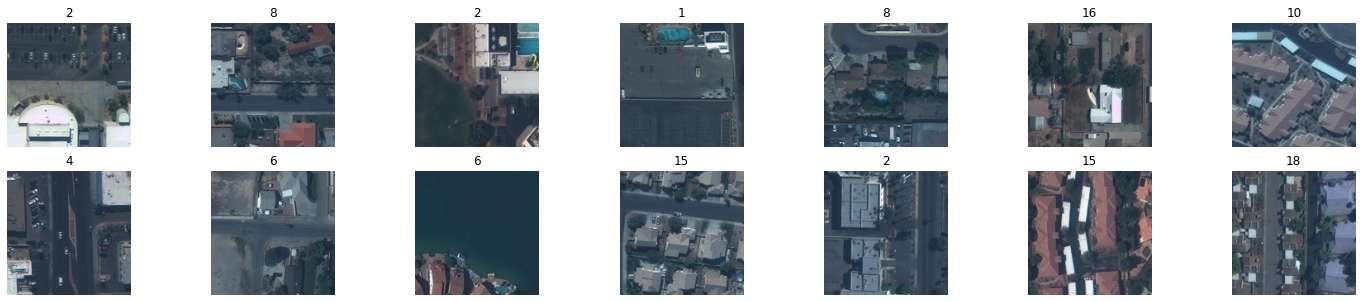

In [5]:
plt.figure(figsize=(25, 5))
sample = np.random.choice(X.shape[0], 7*2)
for i in range(2):
    for j in range(7):
        plt.subplot(2, 7, 7*i + j+1)
        plt.axis('off')
        plt.imshow(X[sample[7*i + j]])
        plt.title(houses_kol.iloc[sample[7*i + j]].number_of_houses)

In [6]:
X = np.array(X, dtype = np.float64)
for ind in range(X.shape[0]):
    print(end='\r')
    print(ind*1000//length/10, '%', end='')
    X[ind] /= np.max(X[ind])
print('\n'+str(X.shape))

99.9 %
(2100, 150, 150, 3)


In [7]:
y = houses_kol.number_of_houses.to_numpy(dtype=np.float64)
y

array([12., 15., 10., ..., 11., 16.,  9.])

In [8]:
X = np.append(X, np.zeros((50, 150, 150, 3)), axis = 0)
y = np.append(y, np.zeros((50)), axis = 0)
X.shape, y.shape

((2150, 150, 150, 3), (2150,))

In [9]:
def train_datagen(X, y, batch_size):
    """Replaces Keras' native ImageDataGenerator."""
    while True:
        image_batch = []
        label_batch = []
        for _ in range(batch_size):
            indexs = np.random.randint(0, X.shape[0], size = (4))
            X_new = np.vstack([np.hstack([X[indexs[0]], X[indexs[1]]]), 
                               np.hstack([X[indexs[2]], X[indexs[3]]])])
            y_new = sum(y[indexs])
            image_batch.append(X_new)
            label_batch.append(y_new)

        yield (np.array(image_batch), np.array(label_batch))

In [10]:
index = 0
def test_datagen(X, y):
    global index
    """Replaces Keras' native ImageDataGenerator."""
    while True:
        if index < X.shape[0]:
            zeros = np.zeros((150, 150, 3))
            X_new = np.vstack([np.hstack([X[index], zeros]), 
                            np.hstack([zeros, zeros])])
            y_new = y[index]
            index += 1
            yield (X_new[None, ...], y_new[None, ...])
        else:
            break

In [11]:
def build_model():
    input = Input((300, 300, 3), name='Input')
    out = Conv2D(30, (3, 3), padding='same', activation = 'relu', name = 'Conv11')(input)
    out = Conv2D(30, (3, 3), padding='same', activation = 'relu', name = 'Conv12')(out)
    out1 = MaxPool2D((2, 2), name = 'Maxpool_1')(out)
    out = Conv2D(60, (3, 3), padding='same', activation = 'relu', name = 'Conv21')(out1)
    out = Conv2D(60, (3, 3), padding='same', activation = 'relu', name = 'Conv22')(out)
    out = tf.concat([out1, out], axis = 3)
    out2 = MaxPool2D((2, 2), name = 'Maxpool_2')(out)
    out = Conv2D(120, (3, 3), padding='same', activation = 'relu', name = 'Conv31')(out2)
    out = Conv2D(120, (3, 3), padding='same', activation = 'relu', name = 'Conv32')(out)
    out = tf.concat([out2, out], axis = 3)
    out3 = MaxPool2D((2, 2), name = 'Maxpool_3')(out)
    out = Conv2D(240, (3, 3), padding='same', activation = 'relu', name = 'Conv41')(out3)
    out = Conv2D(240, (3, 3), padding='same', activation = 'relu', name = 'Conv42')(out)
    out = tf.concat([out3, out], axis = 3)
    out4 = MaxPool2D((2, 2), name = 'Maxpool_4')(out)
    out = Conv2D(480, (3, 3), padding='same', activation = 'relu', name = 'Conv51')(out4)
    out = Conv2D(480, (3, 3), padding='same', activation = 'relu', name = 'Conv52')(out)
    out = tf.concat([out4, out], axis = 3)
    out5 = MaxPool2D((2, 2), name = 'Maxpool_5')(out)
    out = Conv2D(960, (3, 3), padding='same', activation = 'relu', name = 'Conv61')(out5)
    out = Conv2D(960, (3, 3), padding='same', activation = 'relu', name = 'Conv62')(out)
    out = tf.concat([out5, out], axis = 3)
    out6 = MaxPool2D((2, 2), name = 'Maxpool_6')(out)
    out = Conv2D(1920, (3, 3), padding='same', activation = 'relu', name = 'Conv71')(out6)
    out = Conv2D(1920, (3, 3), padding='same', activation = 'relu', name = 'Conv72')(out)
    out = tf.concat([out6, out], axis = 3)
    out = MaxPool2D((2, 2), name = 'Maxpool_7')(out)
    out = GlobalAveragePooling2D(name = 'Avarage')(out)
    out = Dense(1000, activation = 'relu', name = 'Dense1')(out)
    out = Dropout(0.4, name = 'Dropout_1')(out)
    out = Dense(800, activation = 'relu', name = 'Dense2')(out)
    out = Dropout(0.2, name = 'Dropout_2')(out)
    out = Dense(1, activation='relu', name = 'Output')(out)
    return Model(inputs=input, outputs=out, name = 'model')

model = build_model()

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv11 (Conv2D)                (None, 300, 300, 30  840         ['Input[0][0]']                  
                                )                                                                 
                                                                                                  
 Conv12 (Conv2D)                (None, 300, 300, 30  8130        ['Conv11[0][0]']                 
                                )                                                             

In [17]:
def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [18]:
def compile_model():
    loss = MeanSquaredError()
    optim = Adam()
    model.compile(optimizer=optim, loss = loss, metrics = [coeff_determination])
compile_model()

In [19]:
hist = model.fit(
    train_datagen(X, y, 20),
    steps_per_epoch=50,
    epochs=170,
    validation_data=train_datagen(X, y, 20),
    validation_steps=25
)

Epoch 1/170
50/50 [==============================] - 36s 492ms/step - loss: 4282.0947 - coeff_determination: -29.4817 - val_loss: 119.6475 - val_coeff_determination: -0.1533
Epoch 2/170
50/50 [==============================] - 25s 504ms/step - loss: 129.9281 - coeff_determination: -0.1697 - val_loss: 119.7213 - val_coeff_determination: -0.1464
Epoch 3/170
50/50 [==============================] - 25s 508ms/step - loss: 125.3250 - coeff_determination: -0.2027 - val_loss: 120.2046 - val_coeff_determination: -0.0500
Epoch 4/170
50/50 [==============================] - 25s 505ms/step - loss: 118.8815 - coeff_determination: -0.1476 - val_loss: 91.4130 - val_coeff_determination: 0.0963
Epoch 5/170
50/50 [==============================] - 25s 497ms/step - loss: 112.9330 - coeff_determination: -0.1521 - val_loss: 112.8183 - val_coeff_determination: 0.0101
Epoch 6/170
50/50 [==============================] - 25s 493ms/step - loss: 116.6335 - coeff_determination: -0.1050 - val_loss: 107.7920 - va

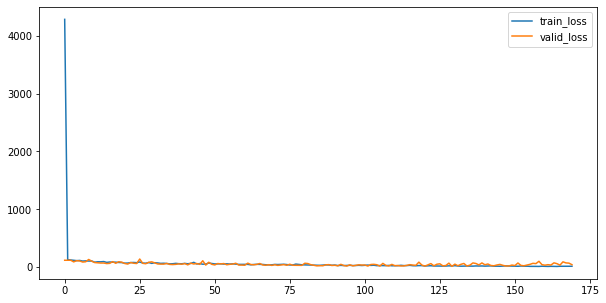

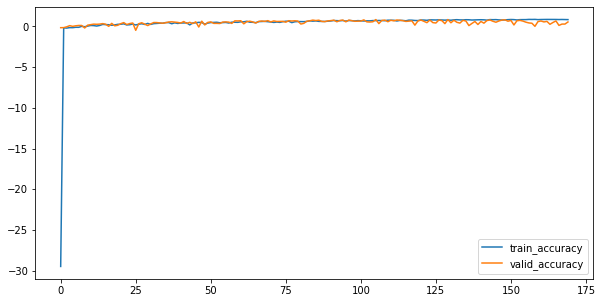

In [21]:
skip = 0
plt.figure(figsize = (10, 5))
plt.plot(hist.history['loss'][skip:], label='train_loss')
plt.plot(hist.history['val_loss'][skip:], label='valid_loss')
plt.legend()
plt.show()
plt.figure(figsize = (10, 5))
plt.plot(hist.history['coeff_determination'][skip:], label='train_accuracy')
plt.plot(hist.history['val_coeff_determination'][skip:], label='valid_accuracy')
plt.legend()
plt.show()

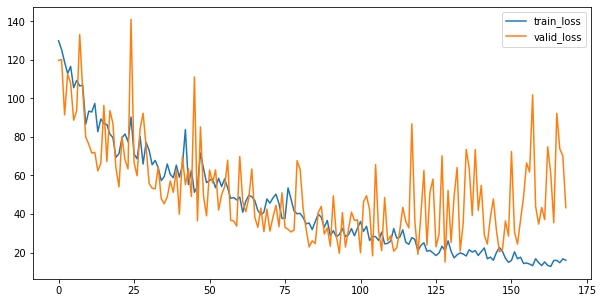

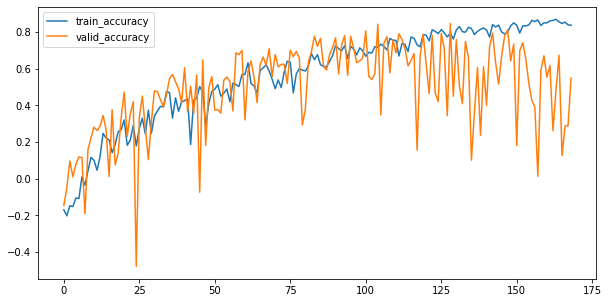

In [22]:
skip = 1
plt.figure(figsize = (10, 5))
plt.plot(hist.history['loss'][skip:], label='train_loss')
plt.plot(hist.history['val_loss'][skip:], label='valid_loss')
plt.legend()
plt.show()
plt.figure(figsize = (10, 5))
plt.plot(hist.history['coeff_determination'][skip:], label='train_accuracy')
plt.plot(hist.history['val_coeff_determination'][skip:], label='valid_accuracy')
plt.legend()
plt.show()

In [20]:
model.save('drive/MyDrive/Success_Rockets/my_model.h5')

In [ ]:
model = load_model('drive/MyDrive/Success_Rockets/my_model.h5', custom_objects={"coeff_determination": coeff_determination })

In [25]:
index = 0
y_pred = model.predict(test_datagen(X, y), steps = 2100, verbose = 1)

2100/2100 [==============================] - 100s 48ms/step


In [27]:
mean_squared_error(y_pred= y_pred, y_true = y[:2100])

5.591346038175957

In [26]:
r2_score(y_pred= y_pred, y_true = y[:2100])

0.8020639666409182